In [58]:
import pandas as pd
import re
import Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, HashingVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


In [12]:
df = pd.read_csv('reviews.csv')
df.tail()

,userName,content,score
9995,Karyadi Buana,aplikasi nya bagus mudah mndaftar antrian bpjs...,4
9996,Dian Yulianti,memudahkan,5
9997,Afidah Nur,"saya kecewa setiap kali update app BPJS, pasti...",3
9998,Septiyan FajarM,"aplikasi gathell, kakean eror ancen anjheng !!!",1
9999,Lets Go,☺👍,5


In [13]:
df = df[['userName', 'content', 'score']]

In [16]:
## 1. Cleaning Data
df = df[['userName', 'content', 'score']]
df.shape
df = df.drop_duplicates(subset=['content'])
df = df.dropna()
df.shape
# Metode 1: Menggunakan drop
df['content'] = df['content'].astype(str).str.lower()  # Mengubah teks menjadi lowercase
df['content'] = df['content'].replace('false', pd.NA)  # Mengganti 'false' dengan pd.NA (Not Available)
df = df.dropna(subset=['content'])

# Metode 2: Menggunakan boolean indexing
df['content'] = df['content'].astype(str).str.lower()  # Mengubah teks menjadi lowercase
df = df[df['content'] != 'false']
def clean_text(text):
  text = re.sub(r'@[A-Za-z0-9_]+', '', text)
  text = re.sub(r'#\w+', '', text)
  text = re.sub(r'RT[\s]+', '', text)
  text = re.sub(r'https?://\S+', '', text)

  text = re.sub(r'[^A-Za-z0-9 ]', '', text)
  text = re.sub(r'\s+', ' ', text).strip()

  return text

df['content'] = df['content'].apply(clean_text)
df['content'] = df['content'].str.lower()
df.head()

,userName,content,score
0,Pengguna Google,permintaan anda belum dapat di proses terus,2
1,Pengguna Google,tolong aplikasinya dibenahi ambil antrian saja...,1
2,Pengguna Google,sekarang sering eror,5
3,Pengguna Google,sangat memudahkan,4
4,Pengguna Google,udah masuk tapi masuk ke info akses menunya ti...,1


In [21]:
# Stopwords
more_stop_words = []

stop_words = StopWordRemoverFactory().get_stop_words()
stop_words.extend(more_stop_words)

new_array = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemover(new_array)

def stopword(str_text):
  str_text = stop_words_remover_new.remove(str_text)
  return str_text

df['content'] = df['content'].apply(lambda x: stopword(x))

In [ ]:
!pip install -U transformers

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline
pipe = pipeline("text-classification", model="hanifnoerr/Fine-tuned-Indonesian-Sentiment-Classifier")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/530 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("hanifnoerr/Fine-tuned-Indonesian-Sentiment-Classifier")
model = AutoModelForSequenceClassification.from_pretrained("hanifnoerr/Fine-tuned-Indonesian-Sentiment-Classifier")

In [30]:
texts = df['content'].tolist()

results = pipe(texts, batch_size=16)

df['sentiment'] = [r['label'] for r in results]
df['score'] = [r['score'] for r in results]

df.head(30)


,userName,content,score,sentiment,tokens
0,Pengguna Google,permintaan belum di proses terus,0.620200,neutral,"[permintaan, belum, di, proses, terus]"
1,Pengguna Google,aplikasinya dibenahi ambil antrian loding teru...,0.996605,positive,"[aplikasinya, dibenahi, ambil, antrian, lod, #..."
2,Pengguna Google,sekarang sering eror,0.999920,negative,"[sekarang, sering, eror]"
3,Pengguna Google,sangat memudahkan,0.999959,positive,"[sangat, memudahkan]"
4,Pengguna Google,udah masuk masuk info akses menunya masukmasuk...,0.999909,negative,"[udah, masuk, masuk, info, akses, menu, ##nya,..."
5,Pengguna Google,aplikasi nggk pernah rawat,0.999797,negative,"[aplikasi, ngg, ##k, pernah, rawat]"
6,Pengguna Google,dnk diperbaiki masa update akunnya keluar mau ...,0.999923,negative,"[dn, ##k, diperbaiki, masa, update, akun, ##ny..."
7,Pengguna Google,knpa masukan kode referral,0.997819,neutral,"[knp, ##a, masukan, kode, referral]"
8,Pengguna Google,semakin baik,0.999946,positive,"[semakin, baik]"
9,Pengguna Google,apk sampah mempersulit pengobatan,0.999909,negative,"[apk, sampah, mempersulit, pengobatan]"


/tmp/ipython-input-4007229464.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


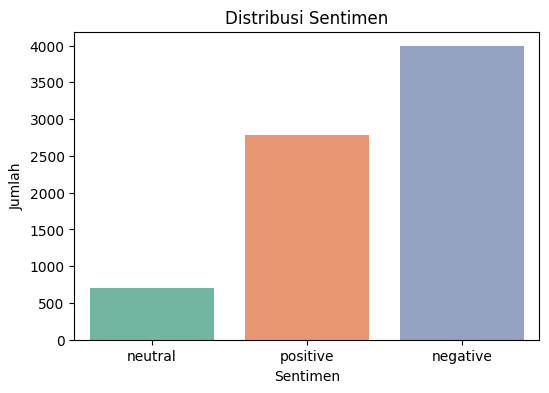

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(
    data=df,
    x='sentiment',
    palette='Set2'
)

plt.title('Distribusi Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()


In [38]:
X=df.content
y=df.sentiment

In [41]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [42]:
print('Banyak data x_train :',len(x_train))
print('Banyak data x_test  :',len(x_test))
print('Banyak data y_train :',len(y_train))
print('Banyak data y_test  :',len(y_test))

Banyak data x_train : 5231
Banyak data x_test  : 2243
Banyak data y_train : 5231
Banyak data y_test  : 2243


In [43]:
cvec=CountVectorizer()
tvec=TfidfVectorizer()
hvec=HashingVectorizer()

In [44]:
clf1 = SVC(kernel="linear")
clf2 = MultinomialNB()
clf3 = RandomForestClassifier()

In [45]:
model1 = Pipeline([('vectorizer',tvec)
                 ,('classifier',clf1)])
model2 = Pipeline([('vectorizer',tvec)
                 ,('classifier',clf2)])
model3 = Pipeline([('vectorizer',tvec)
                 ,('classifier',clf3)])

In [46]:
model1.fit(x_train,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', SVC(kernel='linear'))])

In [47]:
hasil1=model1.predict(x_test)

In [48]:
matrix = classification_report(y_test,hasil1, zero_division=0)
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

    negative       0.86      0.96      0.91      1178
     neutral       0.74      0.26      0.38       208
    positive       0.92      0.92      0.92       857

    accuracy                           0.88      2243
   macro avg       0.84      0.71      0.74      2243
weighted avg       0.87      0.88      0.86      2243



In [49]:
model2.fit(x_train,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', MultinomialNB())])

In [50]:
hasil2=model2.predict(x_test)

In [51]:
matrix = classification_report(y_test,hasil2, zero_division=0)
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

    negative       0.79      0.99      0.88      1178
     neutral       0.00      0.00      0.00       208
    positive       0.95      0.86      0.90       857

    accuracy                           0.85      2243
   macro avg       0.58      0.61      0.59      2243
weighted avg       0.78      0.85      0.80      2243



In [52]:
model3.fit(x_train,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', RandomForestClassifier())])

In [53]:
hasil3=model3.predict(x_test)

In [54]:
matrix = classification_report(y_test,hasil3, zero_division=0)
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

    negative       0.85      0.95      0.90      1178
     neutral       0.93      0.13      0.23       208
    positive       0.89      0.93      0.91       857

    accuracy                           0.87      2243
   macro avg       0.89      0.67      0.68      2243
weighted avg       0.87      0.87      0.84      2243



In [55]:
hasilSupportVectorMachine = accuracy_score(hasil1, y_test)
precision1 = precision_score(y_test, hasil1, average='weighted', zero_division=0)
recall1 = recall_score(y_test, hasil1, average='weighted')
f1_1 = f1_score(y_test, hasil1, average='weighted')

hasilMultinomialNB = accuracy_score(hasil2, y_test)
precision2 = precision_score(y_test, hasil2, average='weighted', zero_division=0)
recall2 = recall_score(y_test, hasil2, average='weighted')
f1_2 = f1_score(y_test, hasil2, average='weighted')

hasilRandomForestClassifier = accuracy_score(hasil3, y_test)
precision3 = precision_score(y_test, hasil3, average='weighted', zero_division=0)
recall3 = recall_score(y_test, hasil3, average='weighted')
f1_3 = f1_score(y_test, hasil3, average='weighted')

In [56]:
model = {'Model':['Support Vector Machine',
                  'Multinomial Naive Bayes',
                  'Random Forest Classifier',
                 ],
         'AccuracyScore':[hasilSupportVectorMachine, hasilMultinomialNB, hasilRandomForestClassifier],
         'Precision':[precision1, precision2, precision3],
         'Recall':[recall1, recall2, recall3],
         'F1-Score':[f1_1, f1_2, f1_3]
         }
model_df = pd.DataFrame(model)
model_df

,Model,AccuracyScore,Precision,Recall,F1-Score
0,Support Vector Machine,0.880071,0.872503,0.880071,0.864300
1,Multinomial Naive Bayes,0.845296,0.777445,0.845296,0.804889
2,Random Forest Classifier,0.866696,0.872532,0.866696,0.839885


In [57]:
!pip install imbalanced-learn


In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

model_svm_smote = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LinearSVC())
])

model_svm_smote.fit(x_train, y_train)


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('smote', SMOTE(random_state=42)),
                ('classifier', LinearSVC())])

In [64]:
from sklearn.metrics import classification_report

y_pred = model_svm_smote.predict(x_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    negative       0.90      0.90      0.90      1178
     neutral       0.50      0.52      0.51       208
    positive       0.92      0.92      0.92       857

    accuracy                           0.87      2243
   macro avg       0.77      0.78      0.78      2243
weighted avg       0.87      0.87      0.87      2243

